In [1]:
import numpy as np
np.set_printoptions(linewidth=1000)

import matplotlib.pyplot as plt

from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit, transpile
from qiskit.quantum_info import Statevector, partial_trace
from qiskit.quantum_info.operators import Operator
from qiskit.circuit.library import UnitaryGate, XGate, ZGate
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram

In [2]:
kappa = 0.5
delta_t = 1

# DnQm
n, m = 3, 18

# NX x NY x NZ
NX = 2
NY = 2
NZ = 2

if n == 2:
    M_0 = NX * NY * 1
    N = [NX, NY]
else:
    M_0 = NX * NY * NZ
    N = [NX, NY, NZ]

In [3]:
# Lattice velocities
cxs_unsorted = []
cys_unsorted = []
czs_unsorted = []

if n == 2:
    if m == 8:
        idxs_dir     = [0, 4,  1,  5, 2,  6,  3,  7]
        cxs_unsorted = [1, 0, -1,  0, 1, -1, -1,  1]
        cys_unsorted = [0, 1,  0, -1, 1,  1, -1, -1]
        
        boundary_idxs_left = [2, 5, 6]
        boundary_idxs_right = [0, 4, 7]
        boundary_idxs_top = [1, 4, 5]
        boundary_idxs_bottom = [3, 6, 7]
    elif m == 16:
        idxs_dir     = [0, 4,  1,  5, 2,  6,  3,  7, 8, 9, 10, 11, 12, 13, 14, 15]
        cxs_unsorted = [1, 0, -1,  0, 1, -1, -1,  1, 2, 1, -1, -2, -2, -1,  1,  2]
        cys_unsorted = [0, 1,  0, -1, 1,  1, -1, -1, 1, 2,  2,  1, -1, -2, -2, -1]

        boundary_idxs_left = [2, 5, 6, 11, 12]
        boundary_idxs_right = [0, 4, 7, 8, 15]
        boundary_idxs_top = [1, 4, 5, 9, 10]
        boundary_idxs_bottom = [3, 6, 7, 13, 14]
    
    boundary_idxs = [boundary_idxs_left, boundary_idxs_right, boundary_idxs_top, boundary_idxs_bottom]
    
    cxs = cxs_unsorted
    cys = cys_unsorted
    
    cs = list(zip(cxs, cys))
elif n == 3:
    if m == 18 or True:
        idxs_dir     = [ 0,  1,  2,  3,  4,  5,  6,  7,  8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
        cxs_unsorted = [-1,  0,  0, -1, -1, -1, -1,  0,  0, 1,  0,  0,  1,  1,  1,  1,  0,  0]
        cys_unsorted = [ 0, -1,  0, -1,  1,  0,  0, -1, -1, 0,  1,  0,  1, -1,  0,  0,  1,  1]
        czs_unsorted = [ 0,  0, -1,  0,  0, -1,  1, -1,  1, 0,  0,  1,  0,  0,  1, -1,  1, -1]

    # @TODO - come up with systematic, programmatic way of generating these
    boundary_idxs_ppp = boundary_idxs_mpp = boundary_idxs_mmp = boundary_idxs_pmp = boundary_idxs_ppm = boundary_idxs_mpm = boundary_idxs_mmm = boundary_idxs_pmm = []
    
    boundary_idxs = [
        boundary_idxs_ppp, boundary_idxs_mpp, boundary_idxs_mmp, boundary_idxs_pmp,
        boundary_idxs_ppm, boundary_idxs_mpm, boundary_idxs_mmm, boundary_idxs_pmm
    ]

    cxs = cxs_unsorted
    cys = cys_unsorted
    czs = czs_unsorted
    
    cs = list(zip(cxs, cys, czs))

print(cs)

[(-1, 0, 0), (0, -1, 0), (0, 0, -1), (-1, -1, 0), (-1, 1, 0), (-1, 0, -1), (-1, 0, 1), (0, -1, -1), (0, -1, 1), (1, 0, 0), (0, 1, 0), (0, 0, 1), (1, 1, 0), (1, -1, 0), (1, 0, 1), (1, 0, -1), (0, 1, 1), (0, 1, -1)]


In [4]:
n_qubits_lattice = int(np.ceil(np.log2(M_0)))
n_qubits_direction = int(np.ceil(np.log2(m)))
n_qubits_switch = 1
n_qubits_ancilla = 3
n_qubits = n_qubits_lattice + n_qubits_direction + n_qubits_switch + n_qubits_ancilla

print(f"Total qubits: {n_qubits}")
print(f"Lattice qubits: {n_qubits_lattice}")
print(f"Direction qubits: {n_qubits_direction}")
print(f"Switch qubits: {n_qubits_switch}")
print(f"Ancilla qubits: {n_qubits_ancilla}")

qreg_lattice = QuantumRegister(n_qubits_lattice, name="L")
qreg_direction = QuantumRegister(n_qubits_direction, name="D")
qreg_switch = QuantumRegister(n_qubits_switch, name="S")
qreg_ancilla = QuantumRegister(n_qubits_ancilla, name="A")
creg_measure = ClassicalRegister(n_qubits, name="C")

Total qubits: 12
Lattice qubits: 3
Direction qubits: 5
Switch qubits: 1
Ancilla qubits: 3


In [5]:
M = 2**n_qubits_lattice

print(f"Number of lattice points: {M_0}")
print(f"Next power of 2: {M}")

I_2 = np.eye((2))
I_M = np.eye((M))
I_2M = np.kron(I_2, I_M)
I_4M = np.kron(I_2, I_2M)
Z_2M = np.zeros_like(I_2M)

coordinate_max = M
coordinate_max_bin = bin(coordinate_max-1)[2:]

m_max_bin = bin(m-1)[2:]

print(int(coordinate_max_bin, 2), len(coordinate_max_bin), int(m_max_bin, 2), len(m_max_bin))

Number of lattice points: 8
Next power of 2: 8
7 3 17 5


In [6]:
idx_coord_map = {}

c = 0
for x in range(NX):
    for y in range(NY):
        for z in range(NZ):
            idx_coord_map[bin(c)[2:].zfill(len(coordinate_max_bin))] = (x, y, z)
            c += 1

coord_idx_map = dict(zip(idx_coord_map.values(), idx_coord_map.keys()))

print(idx_coord_map)
print("---")
print(coord_idx_map)

{'000': (0, 0, 0), '001': (0, 0, 1), '010': (0, 1, 0), '011': (0, 1, 1), '100': (1, 0, 0), '101': (1, 0, 1), '110': (1, 1, 0), '111': (1, 1, 1)}
---
{(0, 0, 0): '000', (0, 0, 1): '001', (0, 1, 0): '010', (0, 1, 1): '011', (1, 0, 0): '100', (1, 0, 1): '101', (1, 1, 0): '110', (1, 1, 1): '111'}


In [7]:
### initial statevector preparation

# initial intensities (not including sources)
I_i = np.zeros(shape=(M, m))

# initial sources
S_i = np.zeros(shape=(M, m))
S_i[int(coord_idx_map[(NX//2*0, NY//2, NZ//2*0)], 2)] = 1/m # @TODO - also test with all zeros

# initial state preparation
# the initial state has the following classical form:
#     (I_0(0,0,0), ..., I_m(NX-1, NY-1, NZ-1))
#   + delta_t/2 (S_0(0, 0, 0), ..., S_m(NX-1, NY-1, NZ-1))
def state_preparation_3d():
    initial_statevector = np.zeros((2**n_qubits))

    anc_bin = "000"

    for coordinate_i in range(coordinate_max):
        coordinate_bin = bin(coordinate_i)[2:].zfill(len(coordinate_max_bin))

        for mu in range(m):
            mu_bin = bin(mu)[2:].zfill(len(m_max_bin))
        
            for s_bin in range(2):
                prob_amp = 0
                
                if s_bin == 0:
                    prob_amp = I_i[coordinate_i, mu]
                else:
                    prob_amp = 0.5 * delta_t * S_i[coordinate_i, mu]
                
                idx_bin = f"0b{anc_bin}{s_bin}{mu_bin}{coordinate_bin}"
                idx_dec = int(idx_bin, 2)
                initial_statevector[idx_dec] = prob_amp

    initial_statevector /= np.linalg.norm(initial_statevector)

    qc = QuantumCircuit(qreg_lattice, qreg_direction, qreg_switch, qreg_ancilla)
    qc.initialize(initial_statevector)

    return qc

In [8]:
# absorption and scattering operation
def absorption_scattering_3d():
    # Original matrix
    A = (1 - kappa * delta_t) * I_2

    # LCU method
    a = 1 - kappa * delta_t
    b = 2 * np.sqrt(1 - a**2)
    
    C_1 = np.array([
        [a + 0.5j * b, 0],
        [0, a + 0.5j * b]
    ])
    
    C_2 = np.array([
        [a - 0.5j * b, 0],
        [0, a - 0.5j * b]
    ])

    # Check that LCU method recovers the original matrix
    assert np.sum(A - 0.5*(C_1 + C_2)) == 0j

    # Construct quantum operations
    U_C1 = Operator(C_1)
    U_C2 = Operator(C_2)

    C1_gate = UnitaryGate(U_C1, label="$C_1$").control(2)
    C2_gate = UnitaryGate(U_C2, label="$C_2$").control(2)

    # Perform quantum circuit composition steps
    qc = QuantumCircuit(qreg_direction, qreg_switch, qreg_ancilla)

    qc.h(qreg_ancilla[0])

    for q in range(n_qubits_direction):
        qc.append(C1_gate, [qreg_ancilla[0]] + qreg_switch[:] + [qreg_direction[q]])
        
        qc.x(qreg_ancilla[0])
        qc.append(C2_gate, [qreg_ancilla[0]] + qreg_switch[:] + [qreg_direction[q]])
        qc.x(qreg_ancilla[0])

    qc.h(qreg_ancilla[0])

    return qc

In [9]:
# absorption and emission operation
def absorption_emission_3d():
    # Original matrix
    B = np.block([
        [I_2M, I_2M],
        [Z_2M, I_2M]
    ])

    # LCU method
    D_1 = I_2
    D_2 = XGate().to_matrix()
    D_3 = ZGate().to_matrix() @ XGate().to_matrix()

    # Check that LCU method recovers the original matrix
    assert np.sum(B - np.kron((D_1 + 0.5 * D_2 + 0.5 * D_3), I_2M)) == 0j

    # Construct quantum operations
    U_D1 = Operator(D_1)
    U_D2 = Operator(D_2)
    U_D3 = Operator(D_3)

    D1_gate = UnitaryGate(U_D1, label="$D_1$").control(2)
    D2_gate = UnitaryGate(U_D2, label="$D_2$").control(2)
    D3_gate = UnitaryGate(U_D3, label="$D_3$").control(2)

    # Perform quantum circuit composition steps
    qc = QuantumCircuit(qreg_switch, qreg_ancilla)

    qc.h(qreg_ancilla[1])
    qc.h(qreg_ancilla[2])
    
    qc.x(qreg_ancilla[2])
    qc.append(D1_gate, qreg_ancilla[1:3] + qreg_switch[:])
    qc.x(qreg_ancilla[2])
    
    qc.append(D2_gate, qreg_ancilla[1:3] + qreg_switch[:])

    qc.append(D3_gate, qreg_ancilla[1:3] + qreg_switch[:])

    qc.h(qreg_ancilla[1])
    qc.h(qreg_ancilla[2])

    return qc

In [10]:
def propagation_3d():
    # Prepare quantum circuit first since we need to construct it on the fly
    qc = QuantumCircuit(qreg_lattice, qreg_direction, qreg_switch)

    for mu in range(m):
        P_mu = np.zeros((M, M))
        
        c_mu = cs[mu]

        mu_bin = bin(mu)[2:].zfill(len(m_max_bin))

        for idx_init_bin, coord_init in idx_coord_map.items():
            # Periodic BCs
            coord_dest = tuple((coord_init[i] + c_mu[i]) % N[i] for i in range(n))
            idx_dest_bin = coord_idx_map[coord_dest]
            
            # idx_init_dec = int(f"0b{mu_bin}{idx_init_bin}", 2)
            # idx_dest_dec = int(f"0b{mu_bin}{idx_dest_bin}", 2)
            idx_init_dec = int(f"0b{idx_init_bin}", 2)
            idx_dest_dec = int(f"0b{idx_dest_bin}", 2)

            # print(coord_init, coord_dest)
            # print(idx_init_bin, idx_dest_bin)
            # print(idx_init_dec, idx_dest_dec)

            P_mu[idx_init_dec, idx_dest_dec] = 1

        U_P_mu = Operator(P_mu)
        
        # @TODO - verify byte-Endianness on the ctrl_state
        ctrl_switch = "0"
        ctrl_direction = mu_bin[::-1]
        ctrl_state = ctrl_switch + ctrl_direction
    
        P_mu_gate = UnitaryGate(U_P_mu, label=f"$P_{mu}$").control(n_qubits_direction + n_qubits_switch, ctrl_state=ctrl_state)

        qc.append(P_mu_gate, qreg_direction[:] + qreg_switch[:] + qreg_lattice[:])

    return qc

def propagation_ang_redist_3d():
    pass

In [11]:
SPCircuit = state_preparation_3d()
ASCircuit = absorption_scattering_3d()
AECircuit = absorption_emission_3d()
PCircuit = propagation_3d()

In [12]:
qreg_head = QuantumRegister(1, name="H")

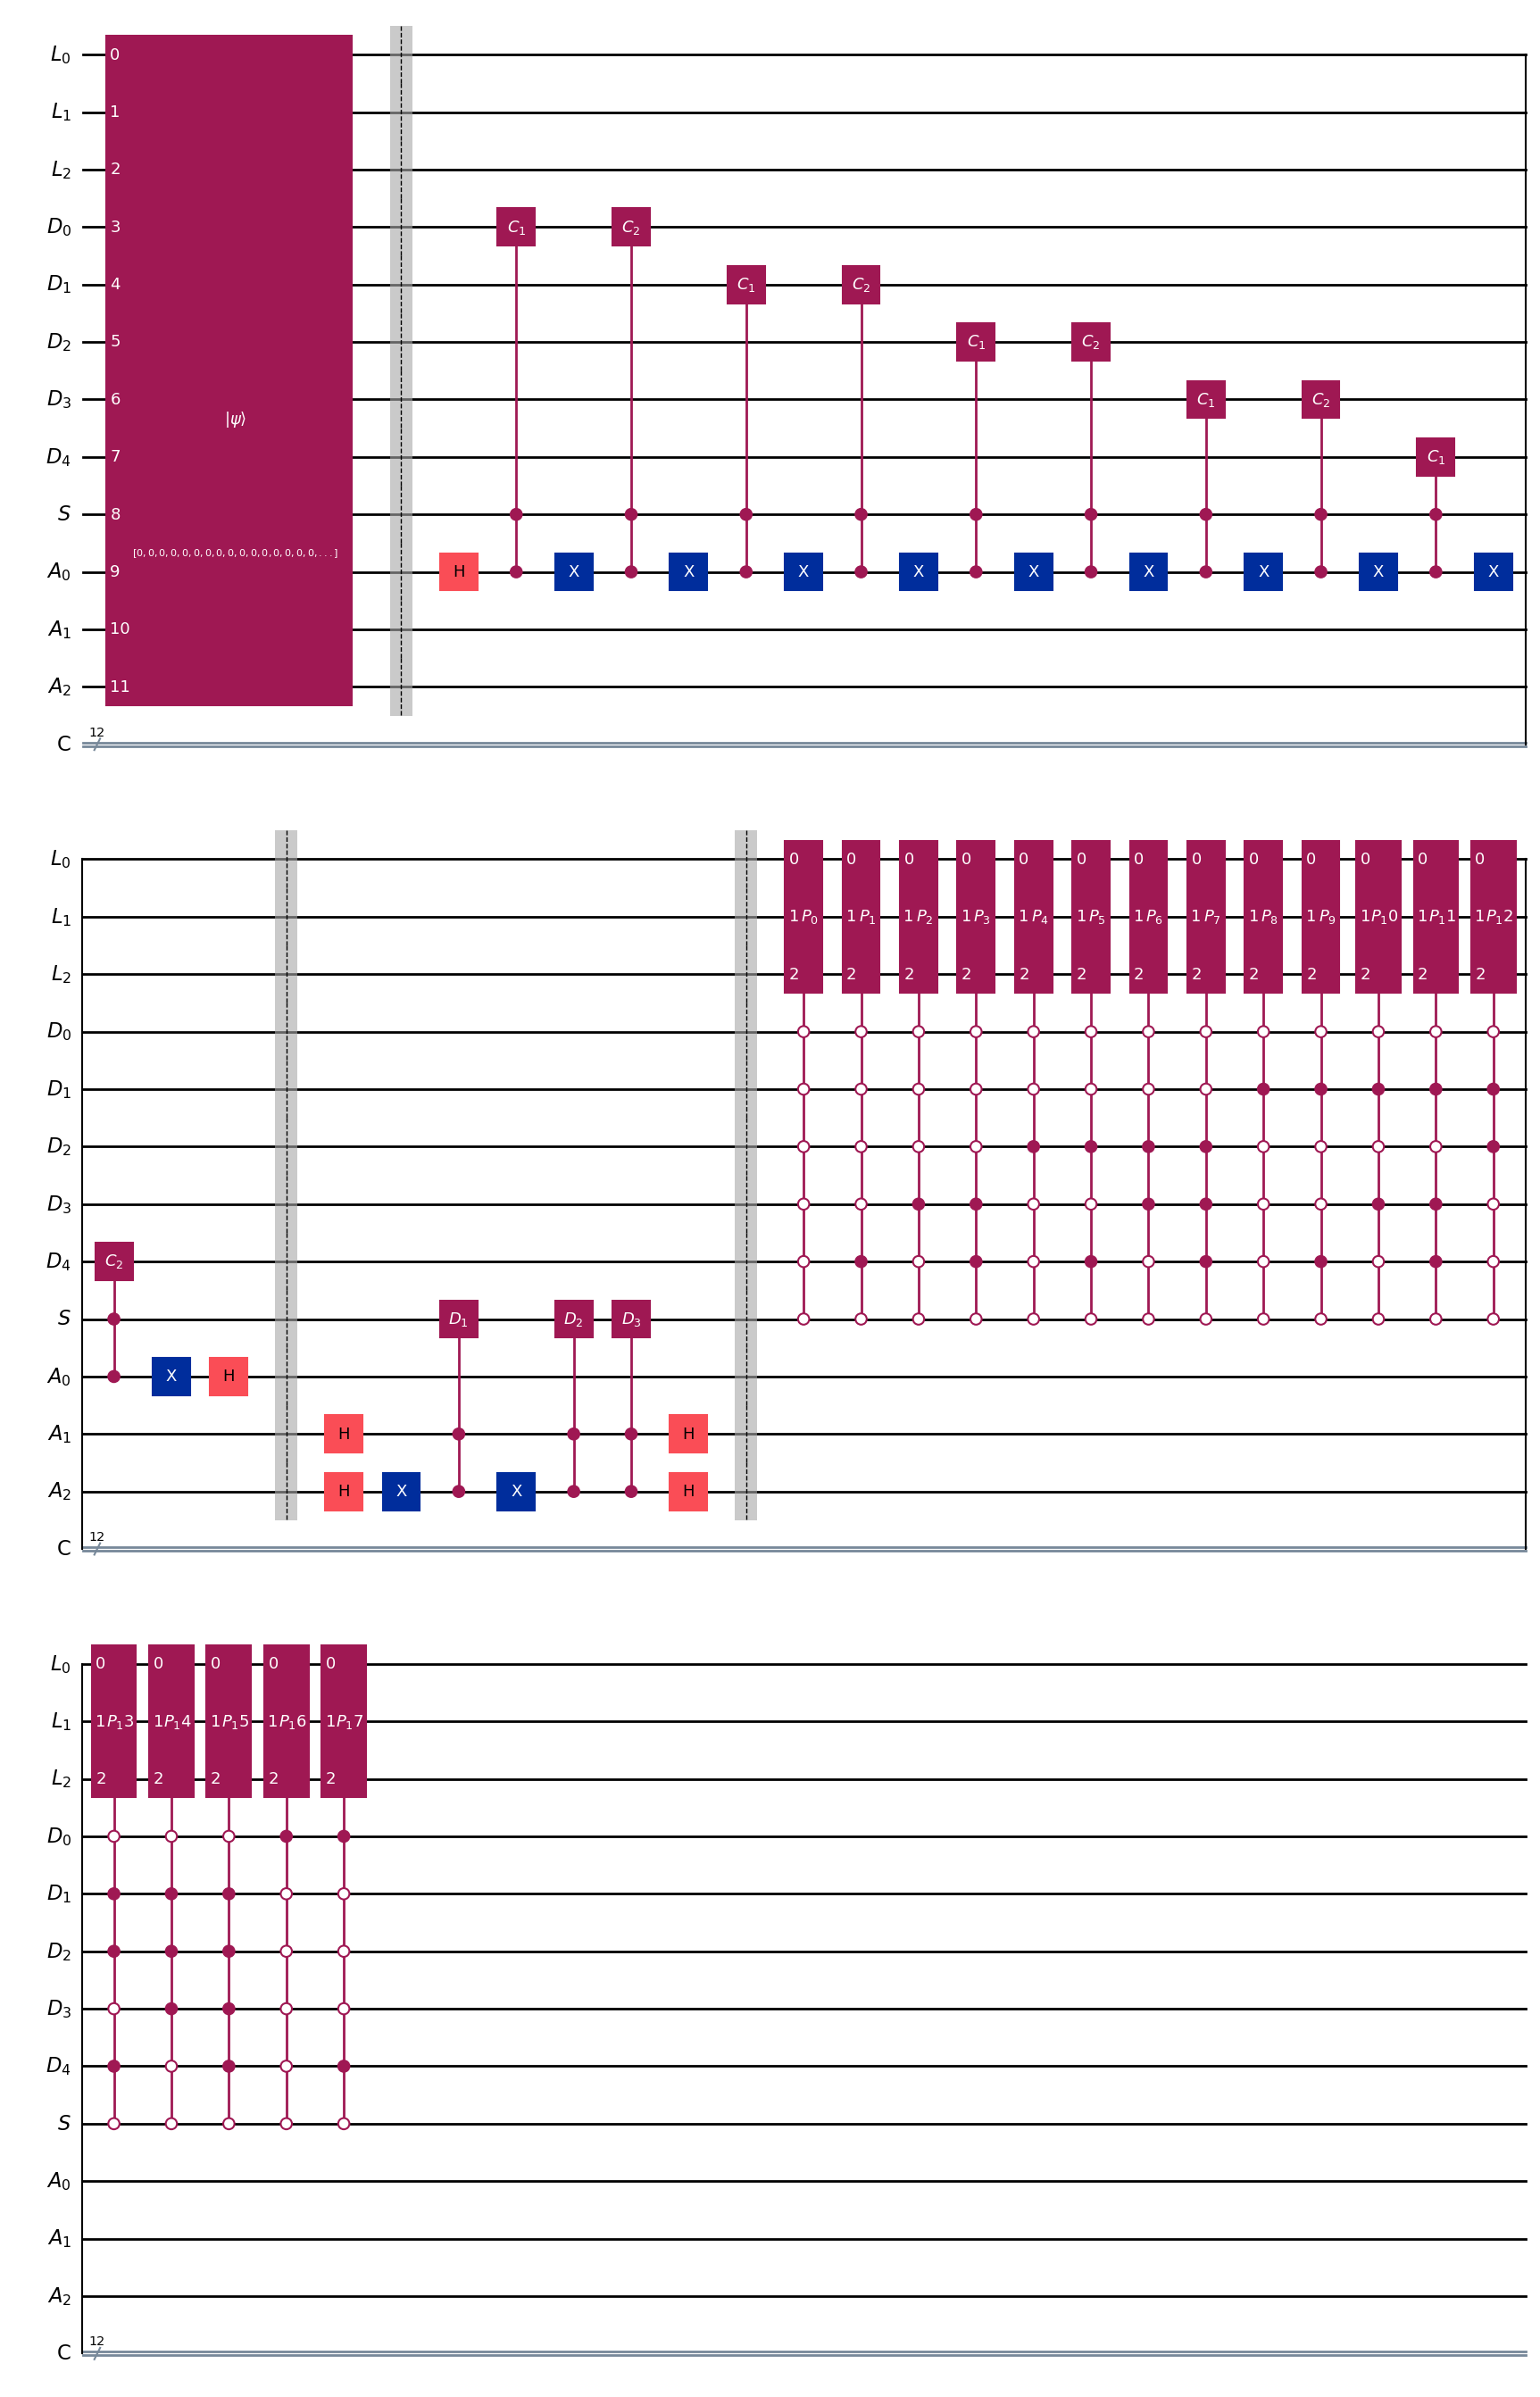

In [13]:
qc = QuantumCircuit(qreg_lattice, qreg_direction, qreg_switch, qreg_ancilla, creg_measure)
# qc = QuantumCircuit(qreg_head, qreg_lattice, qreg_direction, qreg_switch, qreg_ancilla, creg_measure)

expose = True
if expose:
    qc = qc.compose(SPCircuit, qreg_lattice[:] + qreg_direction[:] + qreg_switch[:] + qreg_ancilla[:])
    qc.barrier()
    qc = qc.compose(ASCircuit, qreg_direction[:] + qreg_switch[:] + qreg_ancilla[:])
    qc.barrier()
    qc = qc.compose(AECircuit, qreg_switch[:] + qreg_ancilla[:])
    qc.barrier()
    qc = qc.compose(PCircuit)
else:
    qc.append(SPCircuit.to_instruction(label="$U_{SP}$"), qreg_lattice[:] + qreg_direction[:] + qreg_switch[:] + qreg_ancilla[:])
    qc.append(ASCircuit.to_gate(label="$U_{AS}$"), qreg_direction[:] + qreg_switch[:] + qreg_ancilla[:])
    qc.append(AECircuit.to_gate(label="$U_{AE}$"), qreg_switch[:] + qreg_ancilla[:])
    # qc.append(PCircuit.to_gate(label="$U_{P}$"), qreg_lattice[:] + qreg_direction[:] + qreg_switch[:])

# qc.x(qreg_head)

qc.draw(output="mpl")
# qc.decompose(reps=1).draw(output="mpl")

In [14]:
qc_meas = qc.copy()
qc_meas.measure(qreg_lattice, creg_measure[-n_qubits_lattice:])

sv = Statevector(qc)
sv.draw("latex")

<IPython.core.display.Latex object>

In [15]:
sv_subspace = Statevector([1,0]).tensor(Statevector([1,0])).tensor(Statevector([1,0]))
P_subspace = sv_subspace.to_operator()

sv_proj = sv.evolve(P_subspace, [0,1,2])

In [16]:
sv_L = partial_trace(sv_proj, n_qubits_lattice)
print(np.count_nonzero(sv_L), np.size(sv_L))
sv_L.draw("latex")

65536 4194304


<IPython.core.display.Latex object>

In [ ]:
qc_meas = qc.copy()
qc_meas.measure(range(n_qubits), creg_measure)

device = "GPU" if "GPU" in AerSimulator().available_devices() else "CPU"
cuStateVec_enable = "GPU" in AerSimulator().available_devices()
aer_sim = AerSimulator(method="automatic", device=device, cuStateVec_enable=cuStateVec_enable)
qc_transpiled = transpile(qc_meas, aer_sim, optimization_level=0)
result = aer_sim.run(qc_transpiled, shots=1E4).result()
counts = result.get_counts(qc_transpiled)

counts_post = dict([(measurement, count) for measurement, count in counts.items() if measurement[:3] == "000"])
print(counts)

In [ ]:
plot_histogram(counts, figsize=(24,6))

In [ ]:
lattice = np.zeros((NZ, NY, NX))

print(counts)

for outcome, count in counts.items():
    if outcome[:3] == "000":
        lattice_point_bin = outcome[-n_qubits_lattice:]
        x, y, z = idx_coord_map[lattice_point_bin]
        
        print(lattice_point_bin, (x,y,z))
        
        lattice[z, y, x] += count

print(lattice)

In [ ]:
fig, ax = plt.subplots(ncols=NZ)
for k in range(NZ):
    ax[k].imshow(lattice[k, :, :])
    ax[k].set_title(f"z={k}")